## Homework 1: camera calibration

**Due date:** February 16, 2022

The goal of the assignment is to implement the linear calibration method described in Section 1.3.1 of this [book chapter](https://www.di.ens.fr/%7Eponce/introvis/sbook.pdf).

![calibration-image](img/calibration.jpg)

**Detailed instructions:** The `pts2d` array contains in its columns the (u,v) positions of the image data points (with, by convention, the u and v coordinates with origin at the bottom left of the image, u going right and v going up), while the `pts3d` array contains in its columns the (x,y,z) coordinate vectors of the corresponding 3D points in a right-handed coordinate system. The origin of the world coordinate system is supposed to be in front of the camera, with negative z value.

You should write functions that:
* Compute the 3x4 projection matrix  M estimated from these data using the linear least-squares method of Sec. 1.3.1.
* Compute the corresponding matrix K of intrinsic parameters using the method from M using the method described in the same section.
* Draw together the input image points and the projection of the 3D data points obtained using M to generate a figure like Fig. 1.18, and estimate the root-mean-sqared reprojection error.

You should also write short explanations describing your work and reporting your results.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

pts2d = np.loadtxt("pts2d.txt")
pts3d = np.loadtxt("pts3d.txt")

### Compute projection matrix M

In [2]:
#This function is used to find the P matrix based on original coordinates
def find_P(pts2d, pts3d):
    
    #Homogeneous coordinates
    homo = np.column_stack((pts3d, np.ones(len(pts3d))))
    
    zero = [0] * homo.shape[-1]
    
    P = []
    for i in range(len(pts3d)):
        
        row1 = []
        row2 = []
        
        row1 = np.concatenate((homo[i], zero, - pts2d[i][0] * homo[i]))
        P.append(row1)
        
        row2 = np.concatenate((zero, homo[i], - pts2d[i][1] * homo[i]))
        P.append(row2)
        
    return np.array(P)

In [3]:
#This function is to decompose P matrix and find M
def find_M(pts2d, pts3d):
    
    P = find_P(pts2d, pts3d)
    
    u, s, vh = np.linalg.svd(P, full_matrices=False)
    
    min_s = s[np.argmin(s)]
    min_vh = vh[np.argmin(s), :]
    
    return np.reshape(min_vh, (3,4))

In [4]:
find_M(pts2d, pts3d)

array([[-4.53359881e-03, -5.65451256e-04,  2.02849590e-03,
        -5.23179344e-01],
       [-1.84278426e-03,  4.15975903e-03, -1.68779276e-03,
        -8.52192928e-01],
       [-3.25683227e-06, -1.13804182e-06, -3.35237791e-06,
        -1.43209220e-03]])

### Compute the corresponding matrix K of intrinsic parameters 

In [5]:
# This function calculates the parameters given by equations 1.24 and 1.26, and eventually calculate K based on 1.11
from mpmath import *
def find_K(pts3d):
    
    M = find_M(pts2d, pts3d)
    a1 = M[0][:-1]
    a2 = M[1][:-1]
    a3 = M[2][:-1]
    
    
    rho = 1 / np.linalg.norm(a3)
    
    x0 = rho ** 2 * np.dot(a1, a3)
    y0 = rho ** 2 * np.dot(a2, a3)
    
    
    cosin_theta = - np.dot(np.cross(a1, a3), np.cross(a2, a3)) / (np.linalg.norm(np.cross(a1, a3)) * np.linalg.norm(np.cross(a2, a3)))
    theta = np.arccos(cosin_theta)
    sin_theta = np.sin(theta)
    
    alpha = rho ** 2 * np.linalg.norm(np.cross(a1, a3)) * sin_theta
    beta = rho ** 2 * np.linalg.norm(np.cross(a2, a3)) * sin_theta
    

    K = [alpha, -alpha * (cosin_theta/sin_theta), x0, 0, beta / sin_theta, y0, 0, 0, 1]
    
    return np.reshape(np.array(K), (3,3))

In [6]:
find_K(pts3d)

array([[9.70284101e+02, 9.86348431e-02, 3.72004964e+02],
       [0.00000000e+00, 9.63346581e+02, 2.99292094e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### Plot

In [7]:
#This function is to reproject the coordinates
def find_reprojection(pts2d, pts3d):
    reprojection = []
    
    M = find_M(pts2d, pts3d)
    m1 = M[0]
    m2 = M[1]
    m3 = M[2]
    P = np.column_stack((pts3d, np.ones(len(pts3d))))
    
    for i in range(len(pts3d)):
 
        x = np.dot(m1, P[i]) / np.dot(m3, P[i])
        y = np.dot(m2, P[i]) / np.dot(m3, P[i])

        reprojection.append([x, y])
        
    return np.array(reprojection)

In [8]:
reprojected = find_reprojection(pts2d, pts3d)

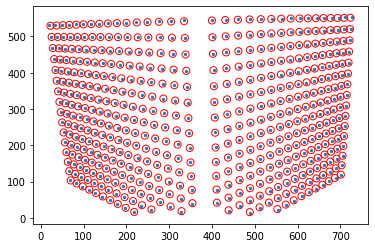

In [9]:
plt.scatter(pts2d[:,0], pts2d[:,1], s=50, facecolors='none', edgecolors='r')
plt.scatter(reprojected[:,0], reprojected[:,1], s = 5)

plt.show()

In [10]:
rmse = math.sqrt(((np.linalg.norm(pts2d - reprojected, axis = 1))**2).mean())

In [11]:
print(f'The root-mean-sqared reprojection error is: {rmse}')

The root-mean-sqared reprojection error is: 0.9573541630433017


Our first task is to find the projection matrix $\mathcal{M}$. But in order to find $\mathcal{M}$, we first need to find $\mathcal{P}$. With the projection equation, we know that $X_i = \frac{m1 \cdot P}{m3 \cdot P}$ and $Y_i = \frac{m2 \cdot P}{m3 \cdot P}$. Based on this equation, we can derive $\mathcal{P}$. Thus the function find_P will return the matrix $\mathcal{P}$ based on the 2d and 3d coordinates. \  
And our goal is to find $\mathcal{M}$ with $\mathcal{P} \mathcal{M} = 0$. Thus, we use singular value decomposition to achieve this. In the function find_M, we first decompose the $\mathcal{P}$ matrix, and then find the eigenvector that is associated with the smallest eigenvalue for $\mathcal{P}$, and obtain the projection matrix $\mathcal{M}$.\
The next step is to find intrinsic parameters, which will be calculated based on $\mathcal{M}$. Based on the definition of rotation and translation matrix, we are able to calculate parameters based on equation 1.24 and 1.26. Then based on the definition of $\mathcal{K}$ from equation 1.11, we obtain the matrix $\mathcal{K}$ of intrinsic parameters.\
Next we will calculate the reprojected coordinates again based on the equation 1.14, and plot them with the original coordinates. Our calculated RMSE is 0.95, which means that our reprojection is pretty close to the original value.